# Импорт библиотек #

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from pathlib import Path
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт данных #

Все данные я заранее скачал загрузил на google drive и выгружать их буду с него

Сылки на датасеты

train: https://drive.google.com/file/d/1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16/view?usp=sharing

test: https://drive.google.com/file/d/12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K/view?usp=sharing

In [3]:
!7z x /content/drive/MyDrive/Курсовая_Классификация_эмоций/train.zip
!7z x /content/drive/MyDrive/Курсовая_Классификация_эмоций/test_kaggle.zip
!7z x /content/drive/MyDrive/Курсовая_Классификация_эмоций/train.csv.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDriv . лассификация_эмоций/                                                                          1 file, 2278474272 bytes (2173 MiB)

Extracting archive: /content/drive/MyDrive/Курсовая_Классификация_эмоций/train.zip
  8% 4096 Open              --
Path = /content/drive/MyDrive/Курсовая_Классификация_эмоций/train.zip
Type = zip
Physical Size = 2278474272

  0%      0% 77 - train/anger/1064.jpg                                0% 111 - train/anger/1095.jpg    

In [4]:
train_df = pd.read_csv('/content/train.csv')
del train_df['Unnamed: 0']

In [5]:
# Словарь для дешифровки предсказаний
categ_df = list(train_df.emotion.unique())
emotion_dict = {i : categ_df[i] for i in range(len(categ_df))}

# Для удобного восприятия переведем наименования эмоций на русский язык
emotion_translate = ['Злость', 'Презрение', 'Отвращение', 'Страх', 'Счастье', 'Нейтральность', 'Грусть', 'Удивление', 'Неуверенность']

# Кол-во классов
NUM_CLASSES = len(list(train_df.emotion.unique()))

# Подготовка генератора изображений #

Подробнее о препроцессинге можно узнать тут: https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py

In [6]:
# Функция препроцессинга необходимоя для модели VGGFace2
def preprocess_input_facenet(image_):
  img = np.copy(image_)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img[..., :: - 1]
  img[..., 0] -= 91.4953
  img[..., 1] -= 103.8827
  img[..., 2] -= 131.0912
  return img

# Функция депроцессинга изображений
def deprocess_image(vggface_image):

  image = vggface_image.copy()
  image = image[:, :, ::-1]
  image[:, :, 2] += 91.4953
  image[:, :, 1] += 103.8827
  image[:, :, 0] += 131.0912
  return np.uint8(image)

In [7]:
# генератор включает в себя функцию препроцессинга, а так же методы аугментации
image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode="nearest")

PATH = '/content/train'
BATCH = 128
IMAGE_SIZE = 224

generator = image_gen.flow_from_directory(batch_size = BATCH, 
                                          directory = PATH, 
                                          shuffle = True, 
                                          class_mode = 'categorical', 
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 50047 images belonging to 9 classes.


In [8]:
images, labels = next(generator)

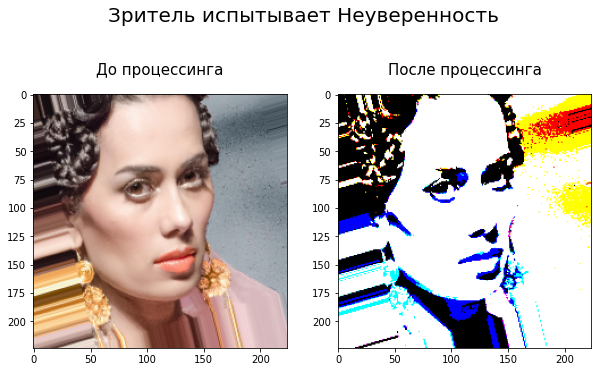

In [9]:
# Изображение получится с эффектом негатива, это нормально
ind = 11

fig, axis = plt.subplots(1, 2, figsize = (10, 10))
plt.suptitle(f'Зритель испытывает {emotion_translate[np.argmax(labels[ind])]}', fontsize = 20, y = 0.8)

axis[1].imshow(images[ind])
axis[1].set_title('После процессинга', fontsize = 15, pad = 20)
axis[0].imshow(deprocess_image(images[ind]))
axis[0].set_title('До процессинга', fontsize = 15, pad = 20)
plt.show()

# Создание модели классификации эмоций #

Ранее на уроках мы мы использовали модель VGGFace2 обученую на лицах занменитых людей и воспользуемся ею и в это раз

Скачать модель можно по ссылке: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO

In [22]:
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/Face_model/resnet50face.h5')
for i in range(len(vgg_model.layers[:166])):
  vgg_model.layers[i].trainable = False

In [23]:
# Отбросим все слои ниже слоя "Flatten_1"
base_model = tf.keras.Model([vgg_model.input], vgg_model.get_layer("flatten_1").output)

# Нарастим модель своими слоями для подгонки под наши данные
classifier_model = tf.keras.models.Sequential([base_model,
                                               tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')])

In [24]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 23,579,593
Trainable params: 3,431,433
Non-trainable params: 20,148,160
_________________________________________________________________


# Обучение модели классификации #

In [11]:
# Сделаем чекпоинт модели(сохраним архитектуру и веса) при лучших показателях accuracy
filename = 'emotion_classifier.h5'
path = Path('/content/drive/MyDrive/Курсовая_Классификация_эмоций/' + filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, 
                                                monitor = 'categorical_accuracy', 
                                                mode = 'max', 
                                                verbose = 1, 
                                                save_best_only = True)

In [10]:
# Данная ячейка предназначена на случай если процесс обучения остановиться не завершившись, 
# тогда мы просто загрузим последний чекпоинт и продолжим обучение(еще не раз пригодится)
restart = True
if restart:
  classifier_model = tf.keras.models.load_model('/content/drive/MyDrive/Курсовая_Классификация_эмоций/emotion_classifier.h5')
  classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 23,579,593
Trainable params: 3,431,433
Non-trainable params: 20,148,160
_________________________________________________________________


In [17]:
classifier_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = 1e-6),
              loss = 'categorical_crossentropy',
              metrics = tf.keras.metrics.categorical_accuracy)

In [ ]:
EPOCHS = 10
hist = classifier_model.fit(generator, epochs = EPOCHS, callbacks = [checkpoint])

In [11]:
# Итоговый показатель accuracy
results = classifier_model.evaluate(images, labels, batch_size=128)

1/1 [==============================] - 26s 26s/step - loss: 0.5800 - categorical_accuracy: 0.8281


# Конвертация модели в tflite #

Подробнеем ожно ознакомиться тут: https://habr.com/ru/post/570052/

In [12]:
# Сохраним модель
classifier_model = tf.keras.models.load_model('/content/drive/MyDrive/Курсовая_Классификация_эмоций/emotion_classifier.h5')
classifier_model.save('saved_model')

In [13]:
# Выгрузив сохраненную модель конвертируем ее в tflite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

In [14]:
# Сохраним конвертированную модель
tflite_model_file = Path('/content/drive/MyDrive/Курсовая_Классификация_эмоций/emotion_classifier.tflite')
tflite_model_file.write_bytes(tflite_model)

94033512

In [15]:
# Выгрузим и настроим
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Курсовая_Классификация_эмоций/emotion_classifier.tflite')
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [16]:
# Пример вывода предсказаний
interpreter.set_tensor(input_index, images[0][None, ...].astype(np.float32))
interpreter.invoke()
pred = np.argmax(interpreter.get_tensor(output_index))

# Инференс #

### Модель ***classifier_model***

In [17]:
# Подгрузим модель
classifier_model = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Курсовая_Классификация_эмоций/emotion_classifier.tflite')
classifier_model.allocate_tensors()
input_index = classifier_model.get_input_details()[0]["index"]
output_index = classifier_model.get_output_details()[0]["index"]

### Запись csv для Kaggle ###

In [18]:
test_file = ['/content/test_kaggle/' + i for i in os.listdir('/content/test_kaggle/')]
test_file_to_predict = []

start = time.time()
emotion_predicts = []

for i in test_file:
    img = image.load_img(i, target_size=(224, 224)) 
    classifier_model.set_tensor(input_index, preprocess_input_facenet(img).astype(np.float32))
    classifier_model.invoke()
    emotion = emotion_dict[np.argmax(classifier_model.get_tensor(output_index))]
    test_file_to_predict.append(np.argmax(classifier_model.get_tensor(output_index)))

end = time.time() - start
print(f'На обработку одного изображения ушло {round(end / 5000, 3)} миллисекунды')

На обработку одного изображения ушло 0.283 миллисекунды


In [19]:
df_subm = pd.DataFrame({'image_path': test_file, 
                        'emotion': test_file_to_predict,})
df_subm.head()

,image_path,emotion
0,/content/test_kaggle/4040.jpg,4
1,/content/test_kaggle/931.jpg,5
2,/content/test_kaggle/522.jpg,5
3,/content/test_kaggle/3121.jpg,5
4,/content/test_kaggle/3419.jpg,0


In [20]:
df_subm['image_path'] = df_subm['image_path'].apply(lambda x: x.split('/')[-1])
df_subm['emotion'] = df_subm['emotion'].map(emotion_dict)
df_subm.to_csv('/content/drive/MyDrive/test.csv', index = False)

На Kaggle по моим предсказаниям результат будет около 0.45

### Передсказания с выводом ###

In [35]:
def show_predict(images_pack, model):

  row_num = images_pack.shape[0] // 4
  i = 0
  fig, axis = plt.subplots(row_num, 4, figsize = (10, 10))

  for row in range(row_num):
    for col in range(4):

      classifier_model.set_tensor(input_index, images_pack[i][None, ...].astype(np.float32))
      classifier_model.invoke()
      emotion = emotion_translate[np.argmax(classifier_model.get_tensor(output_index))]

      axis[row][col].set_title(emotion, pad = 15, fontsize = 12)
      axis[row][col].imshow(deprocess_image(images_pack[i]))
      plt.tight_layout (h_pad= 1)
      axis[row][col].axis('off')
      i += 1

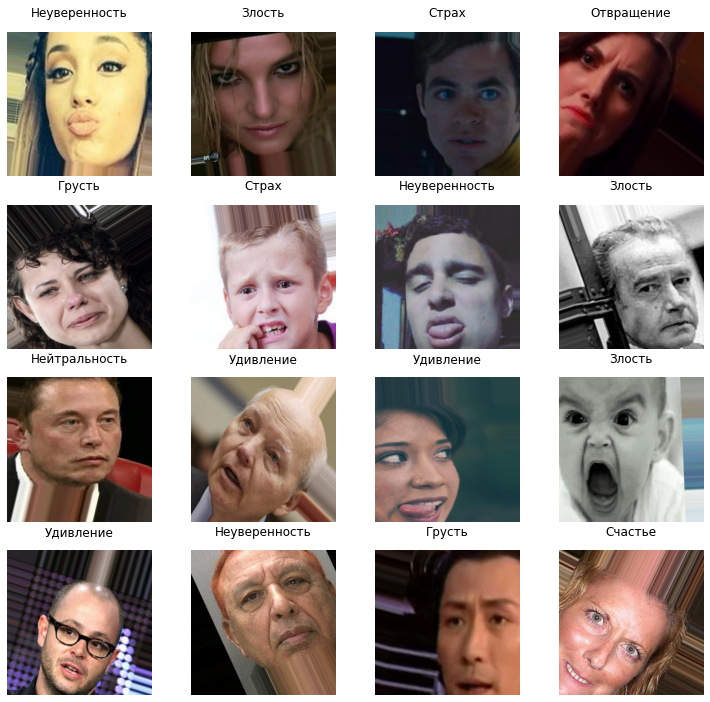

In [36]:
show_predict(images[:16], classifier_model)